In [4]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

encoder = torch.hub.load(
    repo_or_dir="facebookresearch/dinov3",
    weights="weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth",
    source="github",
    model="dinov3_vitl16"
).cuda().eval()

# TODO: Select encoder, DINOv2, DINOv3, and after RASA

Using cache found in .cache/torch/hub/facebookresearch_dinov3_main


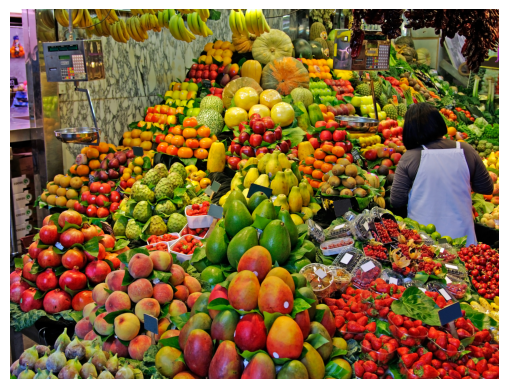

In [31]:
# Load a similar sample to the DINOv3 paper
img = Image.open("./assets/market_boqueria2.jpg").convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()

In [26]:
def cosine_similarity_map(img, coords : list[int], patch_size : int = 16):
    w, h = img.size
    patch_h = h // patch_size
    patch_w = w // patch_size

    # Resize to patch size
    w, h = w - w % patch_size, h - h % patch_size
    img = img.resize((w, h))
    
    # Coordinate to patch token location
    coords[0] = coords[0] // patch_size
    coords[1] = coords[1] // patch_size

    to_tensor_fn = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.485,0.456,0.406),
                    std=(0.229,0.224,0.225)),
    ])
    x = to_tensor_fn(img).unsqueeze(0).cuda()

    with torch.no_grad():
        feats = encoder.forward_features(x)["x_norm_patchtokens"][0]

    # The patch index 
    idx = coords[1] * patch_w + coords[0]
    similarities = F.cosine_similarity(feats[idx].unsqueeze(0), feats)
    
    return similarities.view(patch_h, patch_w).cpu(), coords

def plot_cosine_similarity(img, coords : list[int, int], patch_size : int = 16):
    similarities, (px, py) = cosine_similarity_map(img, coords)
    
    plt.imshow(similarities, cmap="viridis")
    plt.colorbar()
    plt.scatter(px, py, color="red", marker="+", s=100, linewidths=2)
    plt.axis("off")
    plt.show()

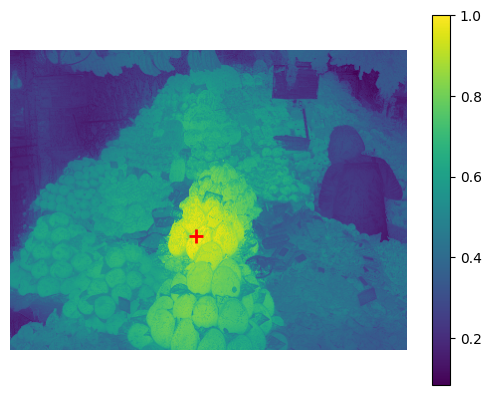

In [24]:
plot_cosine_similarity(img, [3000, 3000])

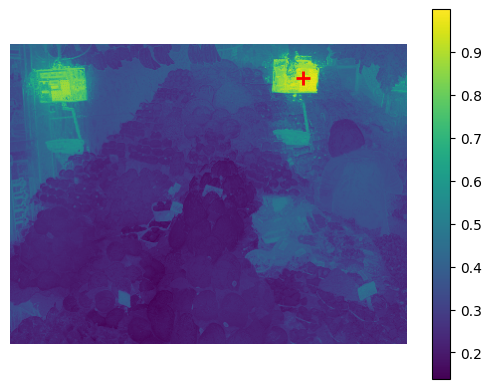

In [28]:
plot_cosine_similarity(img, [4710, 555])

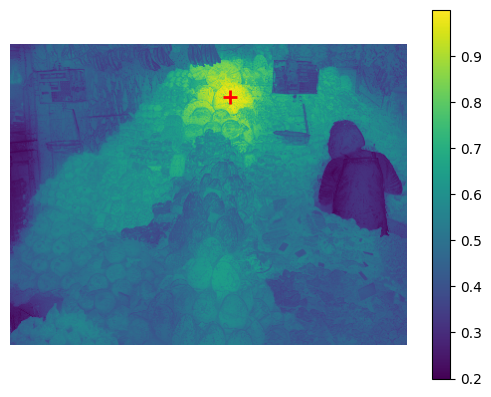

In [27]:
plot_cosine_similarity(img, [3550, 860])

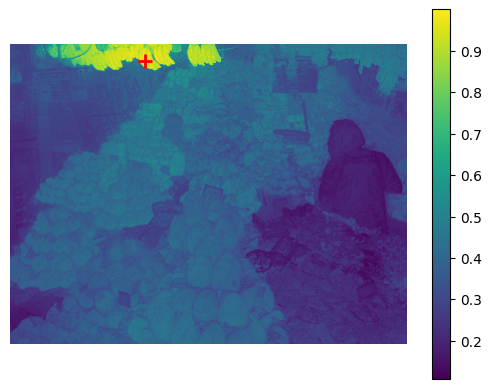

In [29]:
plot_cosine_similarity(img, [2164, 274])